In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [2]:
# Leer archivo txt de dos columnas: tiempo y porcentaje de conversión
archivo1 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C1.txt"
archivo2 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C2.txt"
archivo3 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina.txt"

data_txt1 = pd.read_csv(archivo1, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt2 = pd.read_csv(archivo2, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt3 = pd.read_csv(archivo3, sep="\s+", header=None, names=["Tiempo", "Porcentaje", "Error"])

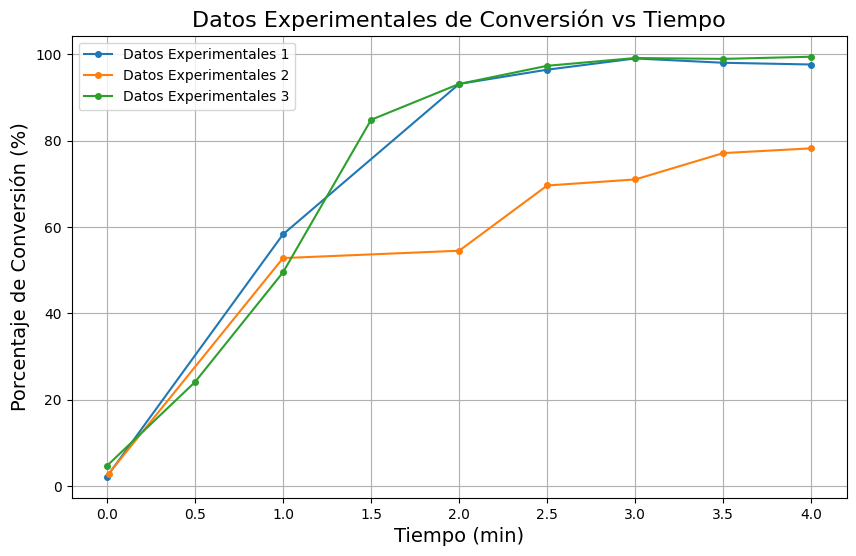

In [3]:
Experiments = [data_txt1, data_txt2, data_txt3]

plt.figure(figsize=(10, 6))
for i, exp in enumerate(Experiments, start=1):
    plt.plot(exp["Tiempo"], exp["Porcentaje"], '-o', label=f'Datos Experimentales {i}', markersize=4)
plt.xlabel('Tiempo (min)', fontsize=14)
plt.ylabel('Porcentaje de Conversión (%)', fontsize=14)
plt.title('Datos Experimentales de Conversión vs Tiempo', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [6]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# =============================
# Utils numéricos robustos
# =============================
_MAX_EXP_ARG = 700.0  # np.exp(700) ~ 1e304 (límite seguro en float64)

def _safe_exp(x: float) -> float:
    """exp(x) con protección contra overflow."""
    if x > _MAX_EXP_ARG:
        x = _MAX_EXP_ARG
    elif x < -_MAX_EXP_ARG:
        x = -_MAX_EXP_ARG
    return float(np.exp(x))

def _finite_or_zero(x: float) -> float:
    """Devuelve x si es finito; 0.0 en caso contrario."""
    return float(x) if np.isfinite(x) else 0.0


# =============================
# Lattice model (SOS approximation)
# =============================
class LatticeSOS:
    """
    Simple solid-on-solid (SOS) lattice with integer column heights.
    - heights[i, j] ∈ {0,1,2,...}
    - 4-neighbor (von Neumann) connectivity with periodic BCs.
    """
    def __init__(self, size: int, seed: Optional[int] = None):
        self.size = size
        self.rng = np.random.default_rng(seed)
        self.heights = np.zeros((size, size), dtype=np.int32)

    def initialize(self, init_mode: str = "flat", max_roughness: int = 1):
        if init_mode == "flat":
            self.heights.fill(0)
        elif init_mode == "random_surface":
            self.heights = self.rng.integers(
                0, max(1, max_roughness+1),
                size=self.heights.shape, dtype=np.int32
            )
        else:
            raise ValueError("Unknown init_mode")

    def wrap(self, idx: int) -> int:
        n = self.size
        return (idx + n) % n

    def neighbors4(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        i, j = site
        return [
            (self.wrap(i-1), j), (self.wrap(i+1), j),
            (i, self.wrap(j-1)), (i, self.wrap(j+1))
        ]

    def get_height(self, site: Tuple[int,int]) -> int:
        return int(self.heights[site])

    def inc_height(self, site: Tuple[int,int], dh: int = 1):
        self.heights[site] += int(dh)

    def dec_height(self, site: Tuple[int,int], dh: int = 1):
        h = int(self.heights[site])
        if h >= dh:
            self.heights[site] = h - dh

    # ---- Site classification helpers ----
    def lateral_neighbors_at_level(self, site: Tuple[int,int], level: int) -> int:
        cnt = 0
        for n in self.neighbors4(site):
            if self.get_height(n) >= level:
                cnt += 1
        return cnt

    def adsorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        return self.lateral_neighbors_at_level(site, h+1)

    def desorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        if h == 0:
            return 0
        return self.lateral_neighbors_at_level(site, h)

    def migration_targets(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        h = self.get_height(site)
        if h == 0:
            return []
        targets = []
        for n in self.neighbors4(site):
            if self.get_height(n) <= h:  # no subir
                targets.append(n)
        return targets

    def get_sites(self) -> List[Tuple[int,int]]:
        idxs = np.argwhere(np.ones_like(self.heights, dtype=bool))
        return [tuple(x) for x in idxs]


# =============================
# Parameters
# =============================
@dataclass
class KMCParams:
    T: float
    K0_plus: float        # prefactor ads/des/mig
    K_inc_plus: float     # prefactor de incorporación
    E_pb_over_kT: float
    phi_over_kT: float
    delta: float
    # supersaturación dinámica
    V: float
    C_eq: float
    S_floor: float = -5.0
    S_ceil: float = 8.0


# =============================
# Adaptive BKL kMC with incorporation (robusto)
# =============================
class KMC_BKL:
    def __init__(self, lattice: LatticeSOS, params: KMCParams,
                 N_bulk0: int, rng_seed: Optional[int] = None,
                 time_scale: float = 1.0, n_seeds: int = 0):
        self.lat = lattice
        self.p = params
        self.rng = np.random.default_rng(rng_seed)

        # Reservas
        self.N0 = int(N_bulk0)   # total inicial para escalar adsorción y conversión
        self.N_bulk = int(N_bulk0)
        self.N_inc = 0

        # Estado temporal
        self.time_scale = float(time_scale)
        self.t = 0.0

        # Bookkeeping
        self.history = []  # (t, evt, site)
        self.counts = {"adsorption":0, "desorption":0, "migration":0, "incorporation":0}

        # Semillas iniciales
        for _ in range(max(0, int(n_seeds))):
            x, y = self.rng.integers(0, lattice.size, size=2)
            self.lat.inc_height((x,y), 1)
            self.N_inc += 1
            self.N_bulk = max(0, self.N_bulk - 1)

    # ---- Supersaturation ----
    @property
    def supersaturation(self) -> float:
        C = self.N_bulk / max(self.p.V, 1e-12)
        S = np.log((C + 1e-15) / max(self.p.C_eq, 1e-15))
        return float(np.clip(S, self.p.S_floor, self.p.S_ceil))

    @property
    def conversion_percent(self) -> float:
        denom = self.N_bulk + self.N_inc
        return 100.0 * (self.N_inc / denom) if denom > 0 else 100.0

    # ---- Rate functions (con safe_exp y clamps) ----
    def r_a(self, i: int) -> float:
        if self.N_bulk <= 0:
            return 0.0
        S = self.supersaturation
        # evitar dividir por S~0: usar signo para no cambiar la física cualitativa
        eps = 1e-12 if S >= 0 else -1e-12
        arg = S + i * (self.p.delta / max(S, eps))
        base = self.p.K0_plus * _safe_exp(arg)
        # factor de reserva finita (empuja a meseta)
        base *= (self.N_bulk / max(self.N0, 1))
        return _finite_or_zero(base)

    def r_d(self, i: int) -> float:
        arg = self.p.phi_over_kT - i * self.p.E_pb_over_kT
        val = self.p.K0_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    def r_m(self, i: int) -> float:
        arg = self.p.phi_over_kT + 0.5*self.p.E_pb_over_kT - i*self.p.E_pb_over_kT
        val = self.p.K0_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    def r_inc(self, i: int) -> float:
        arg = i * self.p.E_pb_over_kT
        val = self.p.K_inc_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    # ---- Classify sites ----
    def _classify_adsorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            i = self.lat.adsorption_bonds(s)
            bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_desorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_migration_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                targets = self.lat.migration_targets(s)
                if not targets:
                    continue
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),3)].append(s)
        return bins

    def _classify_incorporation_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        # aquí usamos mismos sitios ocupados; i>0 favorece incorporación
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    # ---- Event type selection ----
    def _choose_event_type(self, Wa, Wd, Wm, Wi) -> str:
        Wtot = Wa + Wd + Wm + Wi
        if not np.isfinite(Wtot) or Wtot <= 0.0:
            return "none"
        r = self.rng.random() * Wtot
        if r < Wa: return "adsorption"
        r -= Wa
        if r < Wd: return "desorption"
        r -= Wd
        if r < Wm: return "migration"
        return "incorporation"

    def _choose_class(self, weights: Dict[int, float]) -> int:
        total = sum(weights.values())
        if not np.isfinite(total) or total <= 0.0:
            # fallback: tomar la clase con mayor peso válido
            return max(weights, key=weights.get)
        r = self.rng.random() * total
        cum = 0.0
        for i in sorted(weights.keys()):
            w = weights[i]
            cum += w
            if r <= cum:
                return i
        return max(weights, key=weights.get)

    def _choose_site_uniform(self, sites: List[Tuple[int,int]]) -> Tuple[int,int]:
        idx = self.rng.integers(0, len(sites))
        return sites[idx]

    # ---- One kMC step (con defensas) ----
    def step(self) -> bool:
        A_bins = self._classify_adsorption_sites()
        D_bins = self._classify_desorption_sites()
        M_bins = self._classify_migration_sites()
        I_bins = self._classify_incorporation_sites()

        Wa = sum(len(A_bins[i]) * self.r_a(i) for i in A_bins)
        Wd = sum(len(D_bins[i]) * self.r_d(i) for i in D_bins if len(D_bins[i]) > 0)
        Wm = sum(len(M_bins[i]) * self.r_m(i) for i in M_bins if len(M_bins[i]) > 0)
        Wi = sum(len(I_bins[i]) * self.r_inc(i) for i in I_bins if len(I_bins[i]) > 0)

        # Sanitizar pesos
        Wa = _finite_or_zero(Wa); Wd = _finite_or_zero(Wd)
        Wm = _finite_or_zero(Wm); Wi = _finite_or_zero(Wi)
        Wtot = Wa + Wd + Wm + Wi
        if not np.isfinite(Wtot) or Wtot <= 0.0:
            return False

        # tiempo
        z = max(self.rng.random(), 1e-15)
        dt = -np.log(z) / Wtot * self.time_scale
        if not np.isfinite(dt) or dt < 0:
            return False
        self.t += dt

        # evento
        etype = self._choose_event_type(Wa, Wd, Wm, Wi)
        if etype == "none":
            return False

        site = None
        if etype == "adsorption":
            weights = {i: (len(A_bins[i]) * self.r_a(i)) for i in A_bins if len(A_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(A_bins[i_sel])
            self.lat.inc_height(site, 1)
            self.N_bulk = max(0, self.N_bulk - 1)

        elif etype == "desorption":
            weights = {i: (len(D_bins[i]) * self.r_d(i)) for i in D_bins if len(D_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(D_bins[i_sel])
            # sólo si hay GU en la columna
            if self.lat.get_height(site) > 0:
                self.lat.dec_height(site, 1)
                self.N_bulk += 1

        elif etype == "migration":
            weights = {i: (len(M_bins[i]) * self.r_m(i)) for i in M_bins if len(M_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(M_bins[i_sel])
            targets = self.lat.migration_targets(site)
            if targets:
                tgt = targets[self.rng.integers(0, len(targets))]
                if self.lat.get_height(site) > 0 and self.lat.get_height(tgt) <= self.lat.get_height(site):
                    self.lat.dec_height(site, 1)
                    self.lat.inc_height(tgt, 1)

        elif etype == "incorporation":
            weights = {i: (len(I_bins[i]) * self.r_inc(i)) for i in I_bins if len(I_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(I_bins[i_sel])
            # En este esquema "incorporation" cuenta conversión explícitamente en N_inc
            # (la altura ya se manipula en ads/des/mig; aquí sólo contabilizamos el progreso)
            self.N_inc += 1

        self.counts[etype] += 1
        self.history.append((self.t, etype, site))
        return True

    # ---- Run con cierre limpio y snapshots garantizados ----
    def run(self, t_end: float, snapshot_times: Optional[List[float]] = None, max_events: int = 2_000_000):
        snaps: List[Tuple[float, np.ndarray, float]] = []

        # normalizar snapshot_times
        if snapshot_times is None:
            times_list: List[float] = []
        elif isinstance(snapshot_times, np.ndarray):
            times_list = snapshot_times.tolist()
        else:
            times_list = list(snapshot_times)
        times_list = sorted(times_list)

        next_snap_idx = 0
        n_events = 0
        try:
            while self.t < t_end and n_events < max_events:
                print(self.t)
                progressed = self.step()
                if not progressed:
                    break
                n_events += 1
                # guardar snapshots programados
                while next_snap_idx < len(times_list) and self.t >= times_list[next_snap_idx]:
                    snaps.append((times_list[next_snap_idx],
                                  self.lat.heights.copy(),
                                  self.conversion_percent))
                    next_snap_idx += 1
        except Exception as e:
            # Cierre limpio en caso de overflow/NaN u otros
            print(f"⚠️ Simulación detenida por excepción: {e}. Guardando estado parcial...")

        # rellenar pendientes con el último estado conocido
        while next_snap_idx < len(times_list):
            snaps.append((times_list[next_snap_idx],
                          self.lat.heights.copy(),
                          self.conversion_percent))
            next_snap_idx += 1

        return snaps


0.0
0.000634359942296059
0.0029512031490230026
0.0032091641963273463
0.003451339179535547
0.004480184794558065
0.004573547059079546
0.004767764656533748
0.005503537181804456
0.006983230260999527
0.007113481026586581
0.007494457375045313
0.00911705383405766
0.010313327011373326
0.010727241044830341
0.011757568484812145
0.012071222561526821
0.012716576657624896
0.013289372225255235
0.014556973869984802
0.014572396744013826
0.01464390910291932
0.016069860787861254
0.016713239121769006
0.0175867521003815
0.017940269109511416
0.01800669108616991
0.018093538929694387
0.018318236380999067
0.019483811760093776
0.020119379510394664
0.02075216883188721
0.020784136288340756
0.021280136519451535
0.02234771140135206
0.02308834964295754
0.023210892688520845
0.02540307307042944
0.025604935291374708
0.02622546575213864
0.026352103765362633
0.027221599867306673
0.02746557364206703
0.028116342507239604
0.030939631627527164
0.030978089053037533
0.03182747500068237
0.03236064108847202
0.03247925330763801


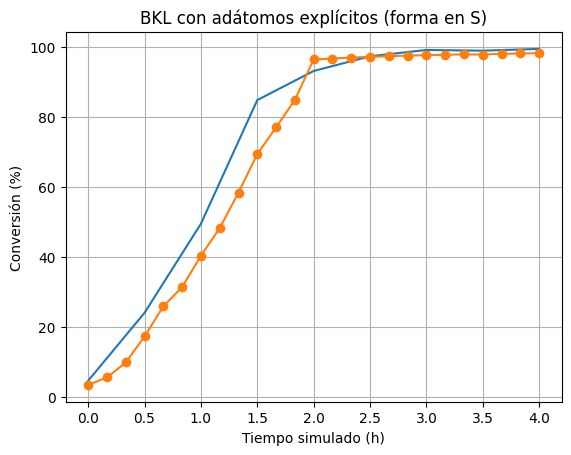

In [18]:
import matplotlib.pyplot as plt

# Lattice y parámetros
L = LatticeSOS(size=30, seed=42)
L.initialize("flat")

params = KMCParams(
    T=298.15,
    K0_plus=1.9,
    K_inc_plus=1.9,
    E_pb_over_kT=0.7,
    phi_over_kT= 1.9,
    delta=3.9,
    V=1.0,
    C_eq=20.0,          # conv_max ~ 95 %
    S_floor=-5.0, S_ceil=8.0
)

kmc = KMC_BKL(L, params, N_bulk0=2000, rng_seed=123, time_scale=200.0, n_seeds=70)


times = np.linspace(0, 10, 25)
snaps = kmc.run(t_end=10, snapshot_times=times)


plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot([t/2.5 for t,_,_ in snaps],
         [conv for _,_,conv in snaps], marker="o")
plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("BKL con adátomos explícitos (forma en S)")
plt.grid(True)
plt.show()


### ⚡ Estrategias de ajuste

#### Acelerar la cinética (misma meseta, menos tiempo)
- $\uparrow K_{0}^{+}$ (más ads/difusión por unidad de tiempo)  
- $\uparrow K_{\text{inc}}^{+}$ (incorporación más rápida)  
- $\downarrow \phi / k_{B}T \;\; \text{o} \;\; \uparrow E_{\text{pb}}/k_{B}T$ (menos desorción neta)  
- $\uparrow \delta$ (más cooperatividad: sube antes la pendiente media)  
- $\downarrow \text{time\_scale}$ (solo reescala el eje $x$; útil para “encajar” en tu ventana)  

#### Más núcleos iniciales
- $\uparrow n_{\text{seeds}}$ reduce el *lag* inicial y empuja la zona media hacia la izquierda.  

#### Mantener la misma meseta
- No cambies $C_{\text{eq}}$ si quieres el mismo $\%$ final.  
- La meseta viene de:


$$\text{conv}_{\max} \approx 1 - \frac{C_{\text{eq}} \, V}{N_{0}}$$

#### Si además quieres subir/bajar el \% final
- Ajusta solo $C_{\text{eq}}$ con:


$$C_{\text{eq}} = (1 - \text{conv}_{\max}) \, \frac{N_{0}}{V}$$
